In [10]:
import itertools
import pandas as pd
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

tlp = "C:\\Users\\jinya\\Desktop\\bio\\data\\fast"
df = pd.read_csv(f"{tlp}\\fast.csv")
df = df[df.Length>75]
hdf = pd.read_csv(f"{tlp}\\fast_humans.csv")
hdf["seq"] = hdf.seq_align.apply(lambda x:x.replace("-",""))


# 数据分布统计

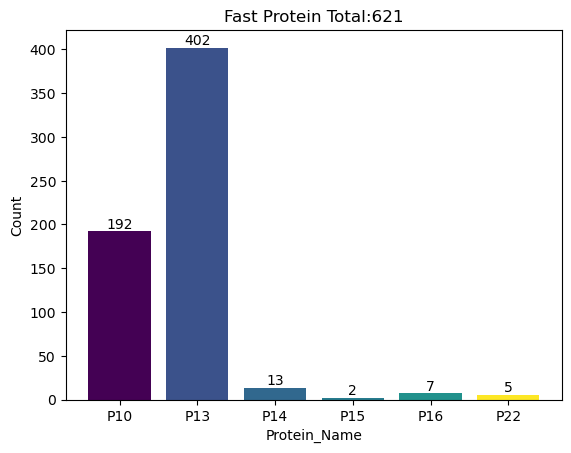

In [2]:
import matplotlib.pyplot as plt
import numpy as np
pdf=df["Protein_Name"].value_counts().to_frame().reset_index().sort_values("Protein_Name")
pdf["index"] = pdf["Protein_Name"].apply(lambda x : int(x[-2:]))
total = pdf["count"].sum()
# 绘图
plt.bar(pdf["Protein_Name"], pdf["count"],color=plt.cm.viridis((pdf["index"].values-10)/12))
for i in range(pdf.shape[0]):
    plt.text(pdf["Protein_Name"][i], pdf["count"][i] + 0.1, str(pdf["count"][i]), ha='center', va='bottom')
plt.xlabel("Protein_Name")
plt.ylabel('Count')
plt.title(f'Fast Protein Total:{total}')
plt.show()

# 识别跨膜区

In [61]:
from Bio import SeqIO
from Bio import pairwise2
import tqdm

class TMUtils(object):
    def __init__(self):
        self.hdf = pd.read_csv(f"{tlp}\\fast_humans.csv")
    
    def most_similar(self,seq):
        max_score,min_score, hit = 0,100, None
        self.hdf["delta"] = np.abs(self.hdf["length"]-len(seq))
        df = self.hdf[self.hdf.delta ==self.hdf.delta.min()]
        for idx, v in df.iterrows():
            alignments = pairwise2.align.globalxx(seq, v.seq)
            alignment = alignments[0]
            score = alignment[2]
            similarity = score / max(len(seq), len(v.seq))
            mscore,_,_= self.match(alignment,v)
            if similarity>max_score:
                max_score = similarity
                hit=v
        return max_score, hit
    
    def match(self,align,s1):
        start,end,idx = -1, -1,0
        for i,ch in enumerate(align.seqA):
            if idx==s1.TM_start:
                start=i
            elif idx==s1.TM_end:
                end =i
            if ch!="-":
                idx+=1
        start2 = len(align.seqB[:start].replace("-",""))
        end2 = len(align.seqB[:end].replace("-",""))
        return abs(end2-start2-21),start2,end2
        

    def align_tm(self, v):
        seq = v.seq
        score,s1=self.most_similar(seq)
        alignments = pairwise2.align.globalxx(s1.seq, seq)
        alignment = alignments[0]
        mscore,start2,end2= self.match(alignment,v)
        return score,seq[start2:end2], start2, end2

utils = TMUtils()
tqdm.tqdm.pandas(desc="Fast Protein align TM")
df[["TM_align_score","TM","TM_start","TM_end"]] = df.progress_apply(utils.align_tm,axis=1, result_type="expand")
df.to_csv(f"{tlp}\\fast_tm.csv",index=False)

Fast Protein align TM: 100%|██████████| 621/621 [00:26<00:00, 23.01it/s]


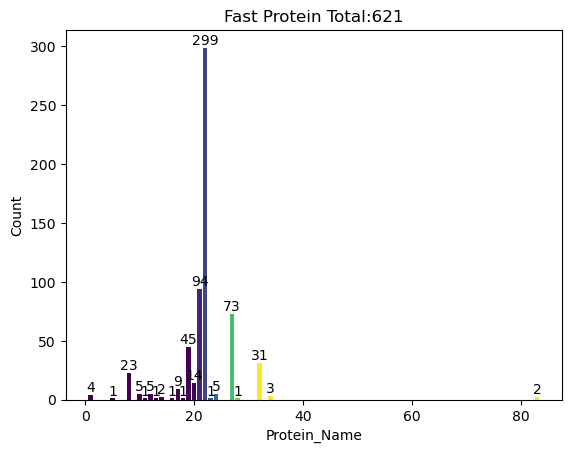

In [62]:
import matplotlib.pyplot as plt
import numpy as np
df["TM_length"] = df["TM_end"] - df["TM_start"]
pdf=df["TM_length"].value_counts().to_frame().reset_index().sort_values("TM_length")
# 绘图
plt.bar(pdf["TM_length"], pdf["count"],color=plt.cm.viridis((pdf["TM_length"].values-20)/10))
for i in range(pdf.shape[0]):
    plt.text(pdf["TM_length"][i], pdf["count"][i] + 0.1, str(pdf["count"][i]), ha='center', va='bottom')
plt.xlabel("Protein_Name")
plt.ylabel('Count')
plt.title(f'Fast Protein Total:{total}')
plt.show()